### Chain Using LangGraph
we are going to see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [1]:
import os 
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)


In [3]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Sharukh Khan"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Sharukh Khan"))

for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Sharukh Khan

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Sharukh Khan

I want to learn python programming language


In [5]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("groq:llama-3.3-70b-versatile")
llm.invoke("Wassup ?")

AIMessage(content="Not much! Just here and ready to chat. What's on your mind? Want to talk about something specific or just shoot the breeze?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 39, 'total_tokens': 68, 'completion_time': 0.08129347, 'completion_tokens_details': None, 'prompt_time': 0.003190468, 'prompt_tokens_details': None, 'queue_time': 0.061919982, 'total_time': 0.084483938}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_68f543a7cc', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c22bc-c240-7751-8c91-536aba4dd437-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 39, 'output_tokens': 29, 'total_tokens': 68})

In [6]:
result = llm.invoke("Which server are you replying from ?")
result.usage_metadata

{'input_tokens': 43, 'output_tokens': 213, 'total_tokens': 256}

In [7]:
result

AIMessage(content="I'm a cloud-based language model, so I don't reply from a specific server in the classical sense. Instead, I'm a distributed system that runs on a network of servers across different locations. When you interact with me, your request is routed to the nearest available server, and my response is generated and sent back to you from that server.\n\nThat being said, I'm a part of the Meta AI infrastructure, which is a global network of servers and data centers. Meta's data centers are located in various regions around the world, including Asia, Europe, and the United States.\n\nIf you're curious, I can tell you that my training data is stored in a distributed manner across multiple servers, and my models are deployed on a variety of cloud platforms, including Amazon Web Services (AWS), Google Cloud Platform (GCP), and Meta's own data centers. However, the specific server that's handling your request at any given time is likely to be a dynamically allocated instance in on

In [8]:
result.response_metadata

{'token_usage': {'completion_tokens': 213,
  'prompt_tokens': 43,
  'total_tokens': 256,
  'completion_time': 0.750067358,
  'completion_tokens_details': None,
  'prompt_time': 0.001980053,
  'prompt_tokens_details': None,
  'queue_time': 0.052363407,
  'total_time': 0.752047411},
 'model_name': 'llama-3.3-70b-versatile',
 'system_fingerprint': 'fp_c06d5113ec',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

TOOL INTEGRATION

In [9]:
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [10]:
# Binding tool with llm

llm_with_tools=llm.bind_tools([add])

tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Krishna Bhagavan")])

In [12]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'drkc9ae2x',
  'type': 'tool_call'}]

Using message as a State

In [13]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

### add_messages is a reducer and its only work is to append new messages to messages

In [14]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages] # 

In [15]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
print(initial_messages)
ai_message

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', tool_calls=[], invalid_tool_calls=[]), HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish')]


AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', tool_calls=[], invalid_tool_calls=[])

see this is how it works

In [16]:
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='ae5bf111-3435-4085-9a1a-f983a4ac60eb', tool_calls=[], invalid_tool_calls=[]),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish', id='d71f0cfe-9091-4d43-8191-9d89c55b88e1'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='d18bdf0f-1e75-46f3-955f-9279aa22c98d', tool_calls=[], invalid_tool_calls=[])]

In [17]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

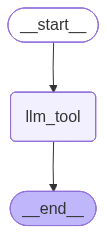

In [18]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# invocation

messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (dey3btp0h)
 Call ID: dey3btp0h
  Args:
    a: 2
    b: 2


In [21]:
tools=[add]

In [31]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)


graph_builder = builder.compile()

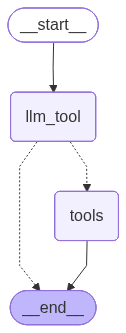

In [32]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

Another way where the tools node calls llm_tool

In [25]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


builder=StateGraph(State)

## Add nodes

builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","llm_tool")
builder.add_edge("llm_tool",END)


graph_builder = builder.compile()

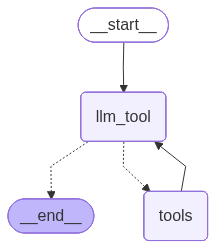

In [26]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [33]:
# invocation

messages=graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (3pz58e5kc)
 Call ID: 3pz58e5kc
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [35]:
messages=graph_builder.invoke({"messages":"What is Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is Machine Learning
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that involves the use of algorithms and statistical models to enable machines to learn from data, make decisions, and improve their performance over time. It allows systems to automatically improve their performance on a task without being explicitly programmed for that task.

There are several key aspects of machine learning:

1. **Data**: Machine learning relies on large amounts of data to learn from. This data can come in many forms, such as images, text, audio, and more.
2. **Algorithms**: Machine learning uses algorithms to analyze the data and make predictions or decisions. These algorithms can be simple or complex, depending on the task at hand.
3. **Training**: Machine learning involves training a model on a dataset, which allows th